<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>Save, compress, and deploy a handwritten digit prediction Keras model</b></font></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr> 
   <tr style="border: none">
       <td style="border: none"><img src="https://github.com/pmservice/wml-sample-models/raw/master/scikit-learn/hand-written-digits-recognition/images/numbers_banner-04.png" width="600" alt="Icon"></td>
   </tr>
</table>

This notebook demonstrates how to train, deploy, and score a Deep Learning model using the Watson Machine Learning. Specifically, it shows you how to save the trained Deep Learning model as a `.tgz` file locally and deploy it online. 

This notebook uses `keras 2.1.6` and `watson-machine-learning-client-V4`.

Some familiarity with Python is helpful. This notebook is compatible with CP4D 2.5 and Python 3.6.


## Learning goals

In this notebook, you will learn how to:

- Use Watson Machine Learning to deploy/score a Deep Learning (Keras) model online.
- Build a Deep Learning (Keras) model and train it.
- Save the trained model as a `.tgz` file in the deployment space.
- Deploy the trained model online and score it.


## Table of Contents

1.	[Setting up](#setup)
2.	[Explore data](#data)<br>
    2.1   [Import the data](#import_the_data)<br>
    2.2   [Display the data](#display_the_data)<br>
    2.3   [Shape the data](#shape_the_data)<br>
3.  [Train and evaluate the model](#train)<br>
    3.1   [Train the model](#train_sub)<br>
    3.2   [Evaluate the model](#evaluate_model)<br>
4.	[Save the model locally](#save)
5.	[Create an online deployment](#deploy)
6.	[Score data](#score)
7.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Setting up

To get started on CP4D, find documentation on installation and set up <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_2.5.0/cpd/overview/welcome.html" target="_blank" rel="noopener no referrer">here</a>.

-  Local Python environment configurations:
  + Python 3.6
  + Keras 2.1.6
  + watson-machine-learning-client-V4 *(run code below to install)*
  + matplotlib *(run code below to install)*<br>

#### Authenticate the Python client on CP4D. 

<div class="alert alert-block alert-info">
    To find your authentication information (your credentials) follow the steps provided here in the <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_2.5.0/wsj/analyze-data/ml-authentication-local.html" target="_blank" rel="noopener no referrer">Documentation</a>.
</div>

**Action:** Enter your credentials in the configuration below.

In [1]:
# Enter your credentials here
import sys,os,os.path
token = os.environ['USER_ACCESS_TOKEN']

wml_credentials = {
"token": token,
"instance_id" : "wml_local",
"url": "---",
"version": "2.5.0"
}

Import the `watson-machine-learning-client` module.
<div class="alert alert-block alert-info">
For more information about the <b>Watson Machine Learning Python client (V4)</b>, please refer to the <a href="https://wml-api-pyclient-dev-v4.mybluemix.net/" target="_blank" rel="noopener no referrer">Python client documentation</a>. If you're using the notebook within a project on your CP4D cluster, you do not need to install this package as it comes pre-installed with the notebooks.
</div>

In [2]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [3]:
client = WatsonMachineLearningAPIClient(wml_credentials)

## 2. Explore the data <a id="data"></a>

In this section, you check what the input data looks like before using them to train the model.
You need the modules `keras.datasets.mnist` and `matplotlib.pyplot` to see what each digit looks like.

### 2.1 Import the data <a id="import_the_data"></a>

Import the MNIST data set from the `keras.datasets.mnist` module and split the data set into training and test data sets.

In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [ ]:
!pip install --upgrade keras==2.1.6

In [ ]:
import keras
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

Import `matlplotlib.pyplot`.

In [7]:
import matplotlib.pyplot as plt

### 2.2 Display the Data <a id="display_the_data"></a>

In [8]:
'''
Parameters of "display_digits" function:

plt     - matplotlib's pyplot module.
images  - The array of images. Ex) X_train, X_test in our example
labels  - Labels of mapping images. 
start   - Start index of "images" array.
end     - End index of "images" array.
num_row - Number of rows.
title   - Title of every image that will be displayed. E.g. 'Training' or 'Test'
'''
def display_digits(plt, images, labels, start, end, num_row, title):
    images_and_labels = list(zip(images, labels))
    num_col = int(end/num_row) if (end % 2 == 0) else int(end/num_row) + 1

    for index, (image, label) in enumerate(images_and_labels[start:end]):
        plt.subplot(num_row, num_col, index + 1)
        plt.axis('off')
        plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title(title + ': %i' % label)

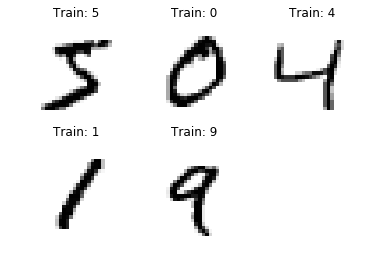

In [9]:
display_digits(plt, X_train, y_train, 0, 5, 2, 'Train')

### 2.3 Shape the Data <a id="shape_the_data"></a>

You can print the shape of the training and test data sets and corresponding label arrays.

In [10]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


Save copies of `X_test` and `y_test` for scoring in the [Score](#score) section before reshaping them in the [Training](#train_sub) section.

In [11]:
X_test_score = X_test.copy()
y_test_score = y_test.copy()

## 3. Train and evaluate the model <a id="train"></a>

In this section, you will build a Deep Learning (Keras) model, train it, and evaluate it.

Import the required package and modules.

In [12]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

### 3.1 Train the model <a id="train_sub"></a>

Set the parameters that are required for the Deep Learning (Keras) model.

In [13]:
batch_size = 128
num_classes = 10
epochs = 6

As you have seen in the section [Explore the data](#data), the image size is 28x28 pixels.

In [14]:
img_rows, img_cols = 28, 28

In [15]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Scale the digits to be of range [0-1] instead of [0-255].

In [16]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Convert the label arrays of training/test digit images into one hot format matrix.

Ex)  
0 => [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
1 => [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]  
2 => [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]  
.  
.  
.  

In [17]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#### 3.1.1 Layers in the model <a id="layers_model"></a>

- Conv2D layer
    - The first 2D convolution layer has 32 output filters and the second 2D convolution layer has 64 output filters.
    - `kernel_size` specifies the height and width of the 2D convolution window.
    - `activation` is a non-linear function that applies to the output of the layer. `relu` (rectified linear unit) clamps all values below 0 to 0.
- MaxPooling layer
    - Max pooling basically moves a `m`x`n` window across a 2D input space where `m` and `n` are both 2 in this example. The max value within the window is the output.
- Dropout layer
    - Helps the model avoid overfitting.
- Dense layer
    - A regular densely-connected neural network layer.
- Flatten layer
    - Flattens the input and doesn't affect the batch size.
- Adadelta 
    - Adapts learning rates based on a moving window of gradient updates instead of accumulating all past gradients. This way, Adadelta continues learning even when many updates occur.

In [18]:
model = Sequential()
model.add(Conv2D(32, 
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Train the model with the parameters you just set.

In [19]:
history = model.fit(X_train,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/6
60000/60000 [==============================] - 130s 2ms/step - loss: 0.2638 - acc: 0.9183 - val_loss: 0.0554 - val_acc: 0.9820
Epoch 2/6
60000/60000 [==============================] - 129s 2ms/step - loss: 0.0880 - acc: 0.9734 - val_loss: 0.0444 - val_acc: 0.9861
Epoch 3/6
60000/60000 [==============================] - 128s 2ms/step - loss: 0.0679 - acc: 0.9802 - val_loss: 0.0338 - val_acc: 0.9889
Epoch 4/6
60000/60000 [==============================] - 129s 2ms/step - loss: 0.0548 - acc: 0.9839 - val_loss: 0.0385 - val_acc: 0.9878
Epoch 5/6
60000/60000 [==============================] - 129s 2ms/step - loss: 0.0476 - acc: 0.9858 - val_loss: 0.0270 - val_acc: 0.9917
Epoch 6/6
60000/60000 [==============================] - 130s 2ms/step - loss: 0.0408 - acc: 0.9877 - val_loss: 0.0290 - val_acc: 0.9895


Plot the model accuracy on the train and validation (test) data sets. With the given code, the graphs are plotted in `R`'s `ggplot` style.

In [20]:
plt.style.use('ggplot')

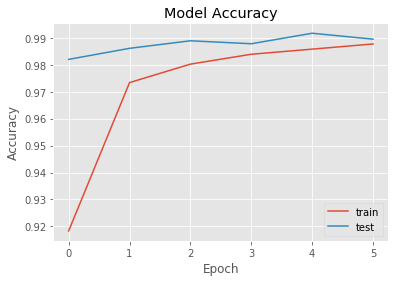

In [21]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')

Plot the model loss on the train and validation (test) data sets.

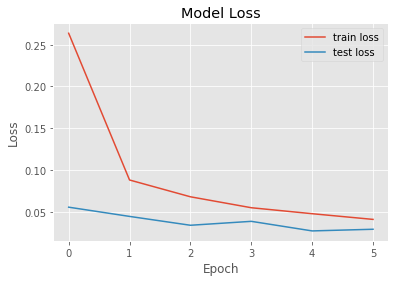

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'test loss'], loc='upper right')

### 3.2 Evaluate the model <a id="evaluate_model"></a>

In this section, you evaluate the model and score its accuracy.

In [23]:
score = model.evaluate(X_test, y_test, verbose=0)

In [24]:
print('Test loss:', score[0])
print('Test accuracy: {:.2f}%'.format(score[1]*100))

Test loss: 0.028982326869637472
Test accuracy: 98.95%


## 4. Save the model locally <a id="save"></a>

In this section, you will learn how to save the trained Deep Learning (Keras) model locally and compress it into a `.tgz` file.

First, save the Keras model locally.

In [25]:
from contextlib import suppress
import os

filename = 'keras_mnist_model.h5'

# Delete a duplicate file if exists.
with suppress(OSError):
    os.remove(filename)
    
model.save(filename)

Compress the Keras model file into a `.tgz` file. Make sure to add the `z` flag when running the `tar` command.

In [26]:
#compress keras model
tar_filename = filename + '.tgz'
cmdstring = 'tar -zcvf ' + tar_filename + ' ' + filename
os.system(cmdstring)

0

You can see that the model file `keras_mnist_model.h5` and its compressed version `keras_mnist_model.h5.tgz` are both saved in the local file system.

In [27]:
!ls

keras_mnist_model.h5  keras_mnist_model.h5.tgz


## 5. Create an online deployment <a id="deploy"></a>

In this section, you learn how to deploy the compressed version, which is the `.tgz` file, of the trained model described in the section [Save the model locally](#save) online.

Define the metadata for the trained model in the section [Train and evaluate the model](#train). You can obtain the space `uid` (one of the Meta Names in the model metadata) by using the following code.

<div class="alert alert-block alert-info">
    You can create your own <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_2.5.0/wsj/analyze-data/ml-spaces_local.html" target="_blank" rel="noopener no referrer">deployment space</a> by selecting <b>Deployment Spaces</b> from the Navigation Menu on the top left of this page.
</div>

Alternatively, you can create a deployment using the code in the following cell. The cell is not executable cell at this stage, but you can enter the name of your space in the metadata and use it if needed.

In [28]:
# Obtain the UId of your space
def guid_from_space_name(client, space_name):
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['guid'])

**Action:** Enter the name of your deployment space in the code below: `space_uid = guid_from_space_name(client, 'YOUR DEPLOYMENT SPACE')`.

In [29]:
# Enter the name of your deployment space here:
space_uid = guid_from_space_name(client, 'YOUR DEPLOYMENT SPACE')
print("Space UID = " + space_uid)

Space UID = 7760d6fb-dff6-4546-84c4-6ac90e4a371a


In [30]:
client.set.default_space(space_uid)

'SUCCESS'

In [31]:
#Model Metadata
meta_props={
    client.repository.ModelMetaNames.NAME: "MNIST - compressed keras model",
    client.repository.ModelMetaNames.RUNTIME_UID: "tensorflow_1.13-py3.6",
    client.repository.ModelMetaNames.TYPE: "keras_2.1.6",
    client.repository.ModelMetaNames.SPACE_UID: space_uid
}

Get the `UID` for the trained model.

In [32]:
# Create the model artifact.
model_artifact = client.repository.store_model(tar_filename,
                                                   meta_props=meta_props,
                                                   training_data=X_train,
                                                   training_target=y_train)
model_uid = client.repository.get_model_uid(model_artifact)
print("Model UID = " + model_uid)

Model UID = dccab1db-13e6-402e-8800-2f3023a48a52


In [33]:
# Details about the model.
model_details = client.repository.get_details(model_uid)
from pprint import pprint
pprint(model_details)

{'entity': {'content_status': {'state': 'persisted'},
            'name': 'MNIST - compressed keras model',
            'runtime': {'href': '/v4/runtimes/tensorflow_1.13-py3.6'},
            'space': {'href': '/v4/spaces/7760d6fb-dff6-4546-84c4-6ac90e4a371a'},
            'type': 'keras_2.1.6'},
 'metadata': {'created_at': '2020-04-24T15:46:30.002Z',
              'guid': 'dccab1db-13e6-402e-8800-2f3023a48a52',
              'href': '/v4/models/dccab1db-13e6-402e-8800-2f3023a48a52?space_id=7760d6fb-dff6-4546-84c4-6ac90e4a371a',
              'id': 'dccab1db-13e6-402e-8800-2f3023a48a52',
              'modified_at': '2020-04-24T15:46:32.002Z',
              'owner': '1000331005'}}


In [34]:
# Display a list of all the models.
client.repository.list_models()

------------------------------------  ------------------------------  ------------------------  -----------
GUID                                  NAME                            CREATED                   TYPE
dccab1db-13e6-402e-8800-2f3023a48a52  MNIST - compressed keras model  2020-04-24T15:46:30.002Z  keras_2.1.6
------------------------------------  ------------------------------  ------------------------  -----------


<div class="alert alert-block alert-info">
    From the list of stored models, you can see that the model is successfully saved in your deployment space. You can view your model by selecting <b>Deployment Spaces</b> from the Navigation Menu and clicking on your deployment space name.
</div>

Now, you can deploy the stored model as a web service (online) by running the following code.

In [35]:
# Deployment metadata.
deploy_meta = {
    client.deployments.ConfigurationMetaNames.NAME: "Keras MNIST model deployment through compressed file.",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

In [36]:
# Create the deployment.
deployment_details = client.deployments.create(model_uid, meta_props=deploy_meta)



#######################################################################################

Synchronous deployment creation for uid: 'dccab1db-13e6-402e-8800-2f3023a48a52' started

#######################################################################################


initializing...
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='ec14758b-c524-4438-88d2-fb6e6c284bd6'
------------------------------------------------------------------------------------------------




Let's list the deployed models.

In [37]:
# List the deployments.
client.deployments.list()

------------------------------------  -----------------------------------------------------  -----  ------------------------  -------------
GUID                                  NAME                                                   STATE  CREATED                   ARTIFACT_TYPE
ec14758b-c524-4438-88d2-fb6e6c284bd6  Keras MNIST model deployment through compressed file.  ready  2020-04-24T15:46:34.530Z  model
------------------------------------  -----------------------------------------------------  -----  ------------------------  -------------


<div class="alert alert-block alert-info">
    From the list of deployments, you can see that the model has been successfully deployed to your deployment space.
</div>

In [38]:
# Deployment UID.
deployment_uid = client.deployments.get_uid(deployment_details)
print('Deployment uid = {}'.format(deployment_uid))

Deployment uid = ec14758b-c524-4438-88d2-fb6e6c284bd6


## 6. Score data <a id="score"></a>

In this section, you learn how to score a test data record.

The first digit of `X_test` will be used for scoring.

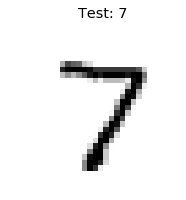

In [39]:
# Prepare scoring payload.
scoring_data = X_test[0].tolist()
job_payload = {
    client.deployments.ScoringMetaNames.INPUT_DATA: [{
        'values': [scoring_data]
    }]
}

display_digits(plt, X_test_score, y_test_score, 0, 1, 1, 'Test')

The map keys 'fields' and 'values' corresponds to their corresponding values in the `scoring payload` dictionary and this scores the model. However, only 'values' will be used in this example. Here, you map 'values' to `scoring_data` in the `scoring payload` dictionary.

In [40]:
# Perform prediction and display the result.
job_details = client.deployments.score(deployment_uid,
                                           job_payload)
pprint(job_details)

{'predictions': [{'fields': ['prediction', 'prediction_classes', 'probability'],
                  'values': [[[9.715852566927197e-10,
                               1.4802910008882009e-08,
                               6.101011962300618e-08,
                               1.6892957432901312e-07,
                               9.362197683771e-10,
                               2.2901429364008408e-10,
                               5.754882112301782e-14,
                               0.9999984502792358,
                               2.1248429682430015e-09,
                               1.3034900803177152e-06],
                              7,
                              [9.715852566927197e-10,
                               1.4802910008882009e-08,
                               6.101011962300618e-08,
                               1.6892957432901312e-07,
                               9.362197683771e-10,
                               2.2901429364008408e-10,
                      

As you can see in the results, the predicted label `prediction_classes` and the true label are the same - `7`.

## 7. Summary and next steps <a id="summary"></a>

You successfully completed this notebook! 
 
You learned how to train, evaluate, and score a Keras model. You also learned how to deploy the model in a `.tgz` format via the `watson-machine-learning-client-V4` package.

### Resources <a id="resources"></a>

To learn more about configurations used in this notebook or more sample notebooks, tutorials, documentation, how-tos, and blog posts, check out these links:

<div class="alert alert-block alert-success">

<h4>IBM documentation</h4>
<br>
 <li> <a href="https://wml-api-pyclient-dev-v4.mybluemix.net" target="_blank" rel="noopener no referrer">watson-machine-learning</a></li> 
 <li> <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_2.5.0/cpd/overview/welcome.html" target="_blank" rel="noopener noreferrer">CP4D 2.5</a></li>
 
<h4> IBM Samples</h4>
<br>
 <li> <a href="https://github.com/IBMDataScience/sample-notebooks" target="_blank" rel="noopener noreferrer">Sample notebooks</a></li>
 
<h4> Others</h4>
<br>
 <li> <a href="https://matplotlib.org" target="_blank" rel="noopener noreferrer">Matplotlib: Python plotting</a></li>
 <li> <a href="https://www.python.org" target="_blank" rel="noopener noreferrer">Official Python website</a><br></li>
 <li> <a href="https://keras.io" target="_blank" rel="noopener noreferrer">Keras: The Python deep learning library</a></li></div>

### Author

**Jihyoung Kim**, Ph.D., is a Data Scientist at IBM who strives to make data science easy for everyone through Watson Studio.

<hr>
Copyright © 2019, 2020 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>